# 1. Imports

In [80]:
import warnings

import pandas  as pd
import seaborn as sns
import numpy   as np

from matplotlib              import pyplot as plt

from IPython.core.display    import HTML
from IPython.display         import Image

from boruta                  import BorutaPy
from sklearn.preprocessing   import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble        import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.metrics         import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics         import roc_auc_score, roc_curve, plot_confusion_matrix

## 1.1. Helper Functions

In [94]:
def jupyter_settings():
    %matplotlib inline

    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25,12]
    plt.rcParams['font.size'] = 11

    display( HTML( '<style>.container { width:80% !important; }</style>' ) )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    pd.set_option( 'display.max_columns', None )

    sns.set_style("darkgrid")
    sns.set_palette("muted")

    warnings.filterwarnings('ignore')
    
def ml_metrics(model_name, y, y_pred):
    
    acc     = accuracy_score( y, y_pred ) 
    prec    = precision_score( y, y_pred )
    rec     = recall_score( y, y_pred )
    f1score = f1_score( y, y_pred ) 
    
    return pd.DataFrame( { 'Model Name': model_name,
                           'Accuracy'  : acc,
                           'Recall'    : rec,
                           'F1 Score'  : f1score }, index=[0] )    

def plot_metrics(model, X, y):
    
    fig, axes = plt.subplots(1,2)
    
    # plot AUC ROC Curve
    y_pred_proba = model.predict_proba(X)[:, 1]
    fpr, tpr, threshholds = roc_curve( y, y_pred_proba )
    auc = roc_auc_score( y_test, y_pred_proba )
    axes[0].plot( fpr, tpr, label='AUC ROC Curve with Area Under the curve = {}'.format(auc) )
    axes[0].legend(loc=4)
    plt.rcParams['font.size'] = 16
    
    # plot confusion matrix
    plot_confusion_matrix(model, X, y_test, ax=axes[1])  
    
    return None

In [64]:
jupyter_settings()

## 1.2. Loading Data

In [6]:
df1 = pd.read_csv( '../data/churn.csv' ).drop( columns='RowNumber' )
df1.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


# 2. Data Description

In [7]:
df2 = df1.copy()

## 2.1. Data Dimensions

In [8]:
print( 'Number of rows: {}'.format( df2.shape[0] ) )
print( 'Number of columns: {}'.format( df2.shape[1] ) )

Number of rows: 10000
Number of columns: 13


## 2.2. Data Types

In [9]:
df2.dtypes

CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

## 2.3. Check NA

In [10]:
df2.isna().sum()

CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

## 2.4. Fillout NA

## 2.5. Change Data Types

In [11]:
df2['HasCrCard'] = df2['HasCrCard'].astype( str )
df2['IsActiveMember'] = df2['IsActiveMember'].astype( str )

## 2.6. Descriptive Statistics

In [12]:
num_attrib = df2.select_dtypes( include=[int, float] )
cat_attrib = df2.select_dtypes( include=object )

### 2.6.1. Numerical Attributes

In [13]:
num_attrib.describe()

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Exited
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,57510.492818,0.402769
min,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,11.580000,0.000000
25%,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,51002.110000,0.000000
50%,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,100193.915000,0.000000
75%,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,149388.247500,0.000000
max,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,199992.480000,1.000000


### 2.6.1. Categorical Attributes

In [14]:
# number of unique values
cat_attrib.apply( lambda x: x.unique().shape[0] )

Surname           2932
Geography            3
Gender               2
HasCrCard            2
IsActiveMember       2
dtype: int64

# 3. Feature Engineering

In [15]:
df3 = df2.copy()

## 3.1. Mind Map

## 3.2. Creating Hypotheses

**1.** The older (Age) the customers, the more likely they are to churn.

**2.** The number of churned customers without a credit card is greater than the ones with credit card. 

**3.** The lower the credit score of the customers, the more likely they are to churn.

**5.** Customers with an estimated salary less than 50000 are more likely to churn.

**6.** Customers who spent less than the average are more likely to churn.

**7.** Customers who were active for less time are more likely to churn.

**8.** Customers who are not active members are more likely to churn.

## 3.3. Creating New Features

# 4. Data Filtering

In [16]:
df4 = df3.copy()

# 5. EDA

In [17]:
df5 = df4.copy()

## 5.1. Univariate Analysis

### 5.1.1. Numerical Attributes

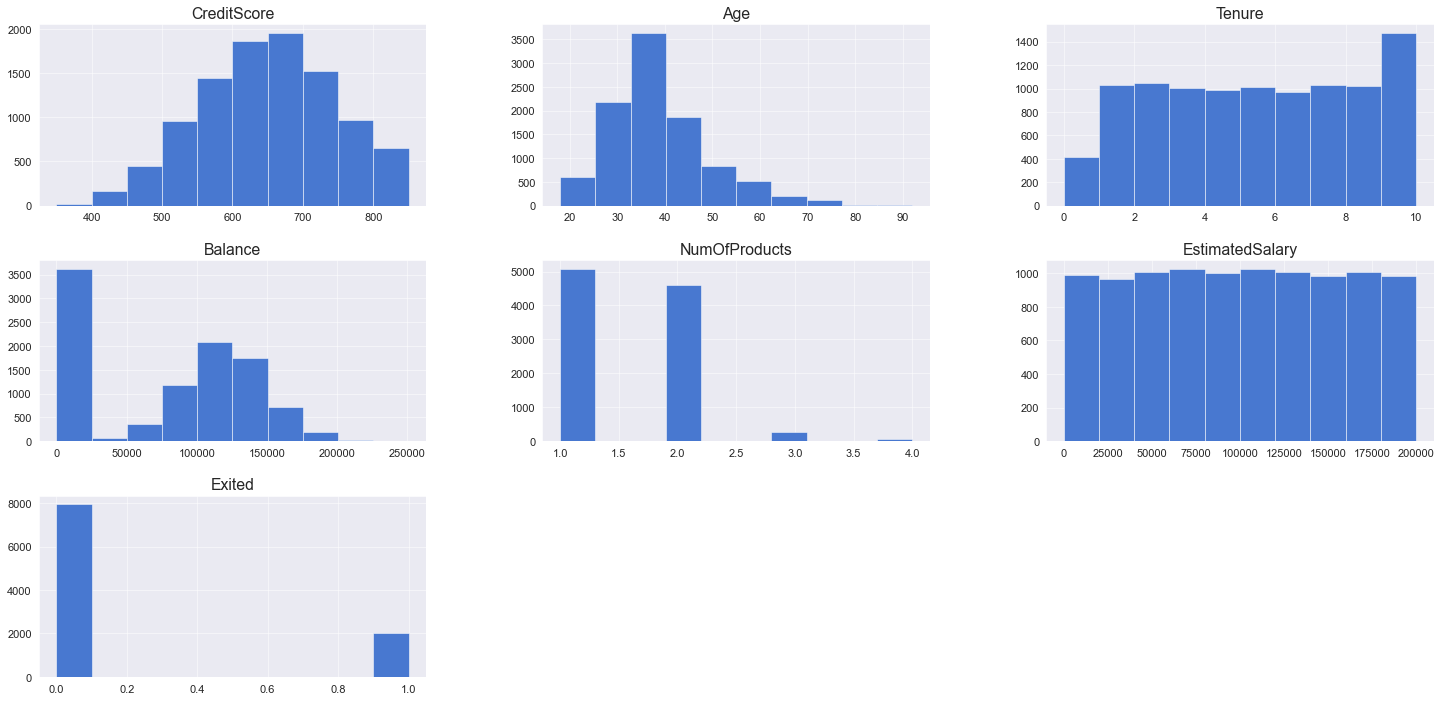

In [18]:
num_attrib.drop( columns='CustomerId' ).hist();

### 5.1.1. Categorical Attributes

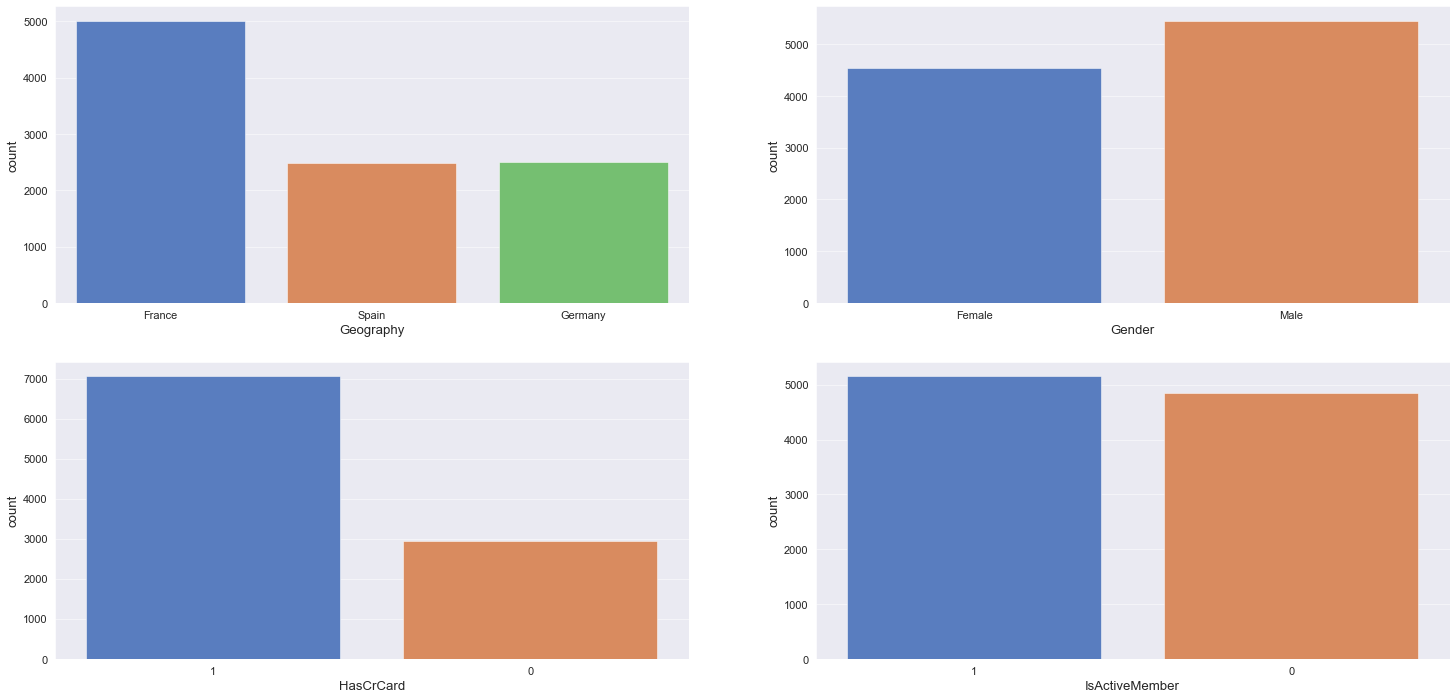

In [19]:
fig, axes = plt.subplots(2,2)

sns.countplot( x='Geography',      data=cat_attrib, ax=axes[0,0] )
sns.countplot( x='Gender',         data=cat_attrib, ax=axes[0,1] )
sns.countplot( x='HasCrCard',      data=cat_attrib, ax=axes[1,0] )
sns.countplot( x='IsActiveMember', data=cat_attrib, ax=axes[1,1] );

## 5.2. Bivariate Analysis 

### H1. The older (Age) the customers, the more likely they are to churn.
* **PARTIALLY TRUE** - Up to 50-56 years the statement is true, however after that the behavior inverts.

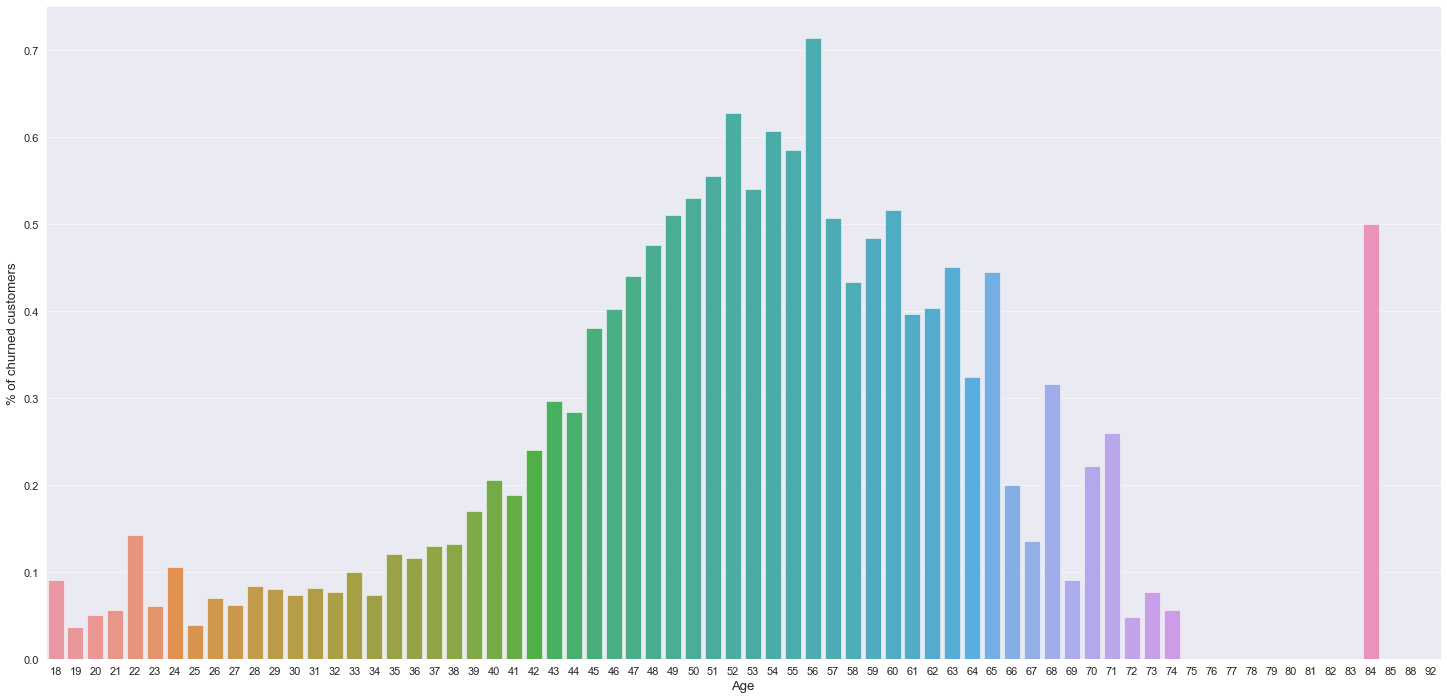

In [20]:
df_aux = df5[['Age', 'Exited']].groupby( 'Age' ).mean().reset_index()
df_aux.rename( columns={'Exited':'% of churned customers'}, inplace=True )

sns.barplot( x='Age', y='% of churned customers', data=df_aux );

### H2. The number of churned customers without a credit card is greater than the ones with credit card. 
* **FALSE** - The number of churned customers without a credit card is **LOWER** than the ones with credit card. 

In [21]:
df_aux = df5[['HasCrCard', 'Exited']].groupby( 'HasCrCard' ).agg({"Exited":["mean", "sum"]})
df_aux.columns = ["Churn Rate", "Nº of customers"]
df_aux

,Churn Rate,Nº of customers
HasCrCard,,
0,0.208149,613
1,0.201843,1424


### H3. The lower the credit score of the customers, the more likely they are to churn.
* **PARTIALLY TRUE** - Up to 450 credit score the statment is true. Especially the customers with a credit score below 400, where the churn rate is 100%.

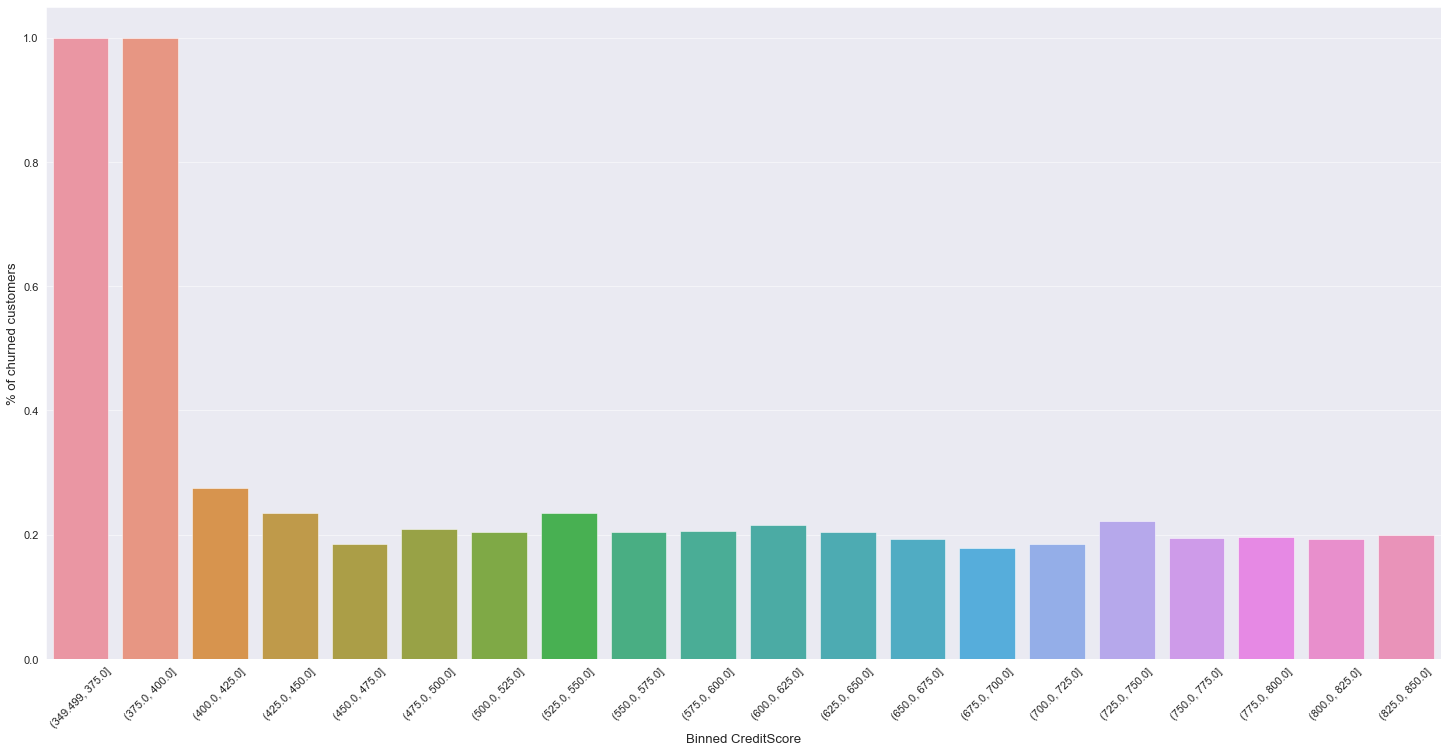

In [22]:
df_aux = df5.copy()
df_aux['Binned CreditScore'] = pd.cut(df_aux['CreditScore'], bins=20, include_lowest=True)

df_aux = df_aux[['Binned CreditScore', 'Exited']].groupby( 'Binned CreditScore' ).mean().reset_index()
df_aux.rename( columns={'Exited':'% of churned customers'}, inplace=True )

sns.barplot( x='Binned CreditScore', y='% of churned customers', data=df_aux)
plt.xticks(rotation=45);

### H4. Customers who bought just one product are more likely to churn.
* **FALSE** - Customers who bought **four** products are more likely to churn.

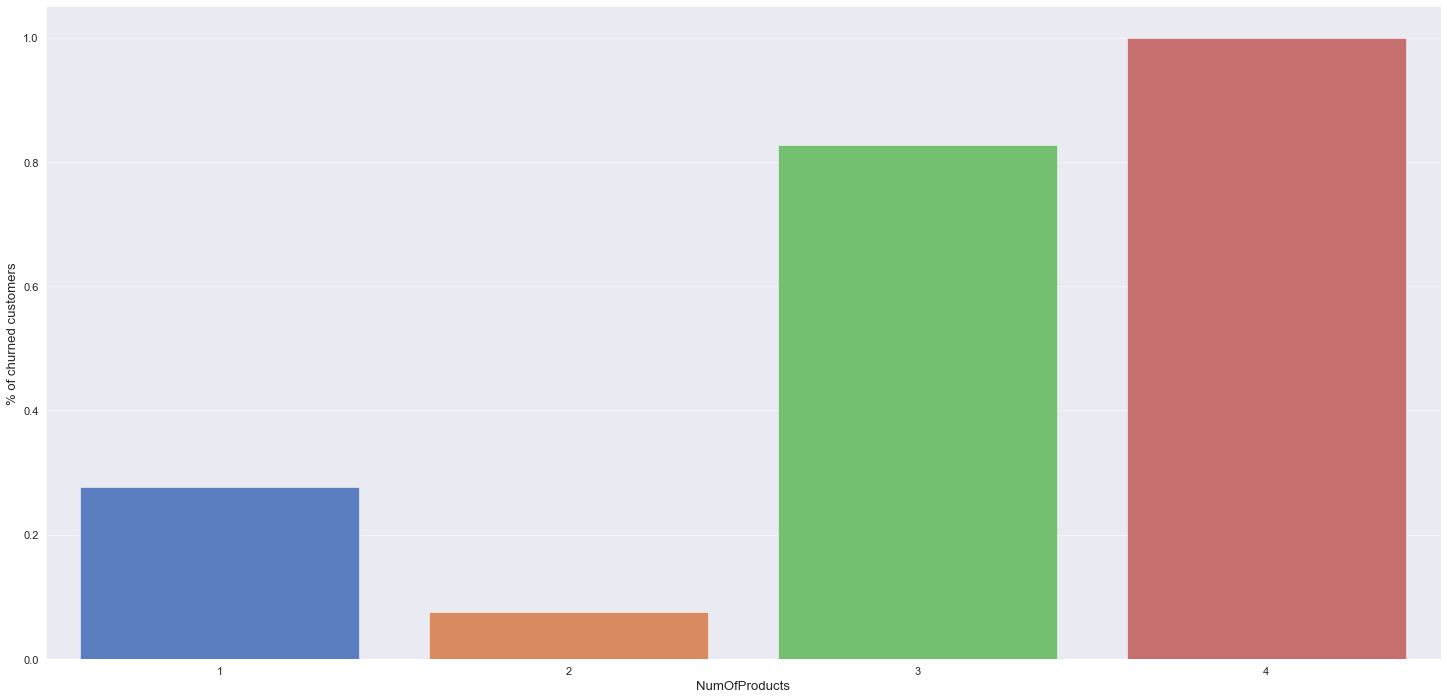

In [23]:
df_aux = df5[['NumOfProducts', 'Exited']].groupby( 'NumOfProducts' ).mean().reset_index()
df_aux.rename( columns={'Exited':'% of churned customers'}, inplace=True )

sns.barplot( x='NumOfProducts', y='% of churned customers', data=df_aux);

### H5. Customers with an estimated salary less than 50000 are more likely to churn.
* **FALSE** - There is no direct correlation between salary and churn rate.

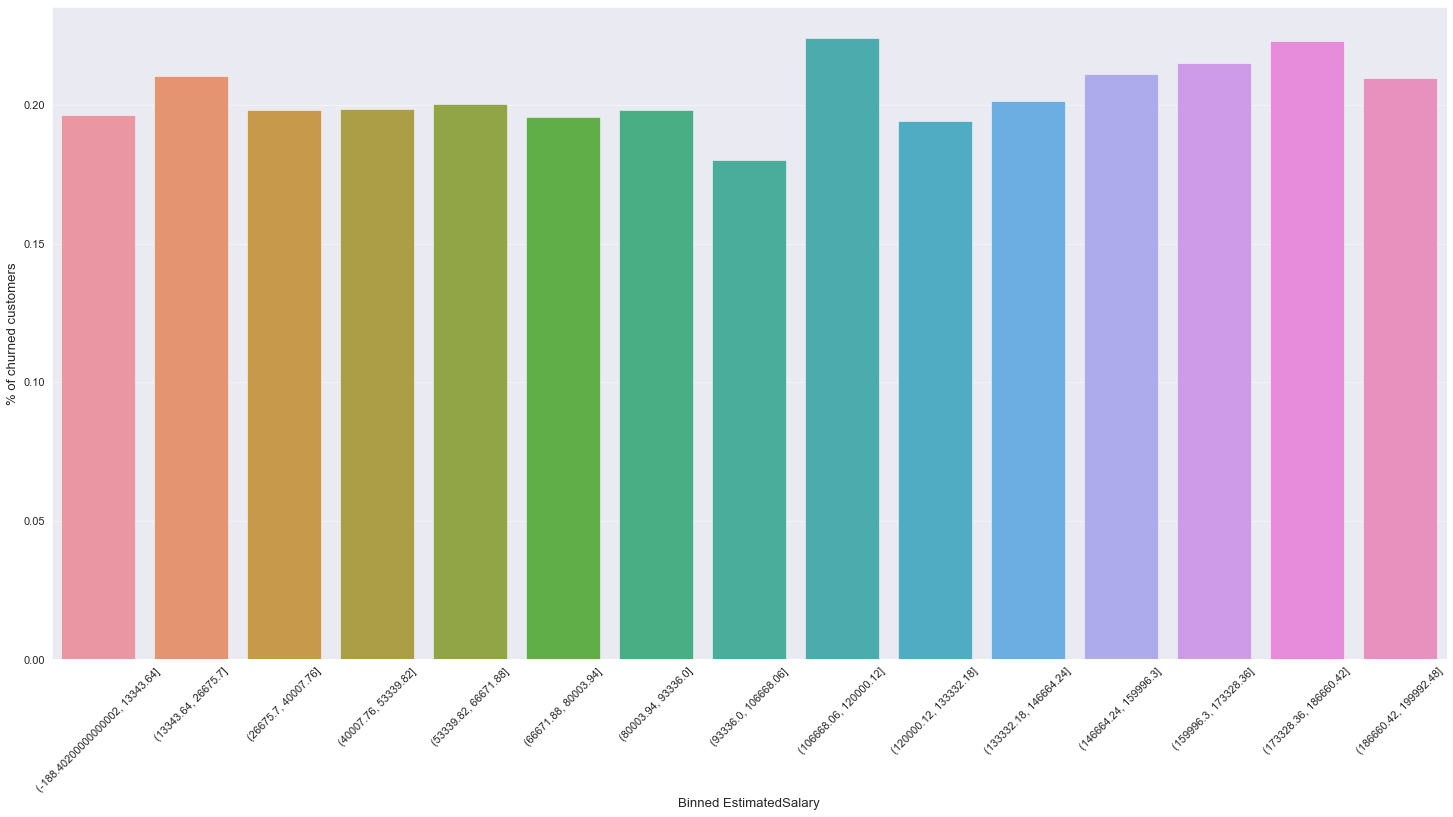

In [24]:
df_aux = df5.copy()
df_aux['Binned EstimatedSalary'] = pd.cut(df_aux['EstimatedSalary'], bins=15, include_lowest=True)

df_aux = df_aux[['Binned EstimatedSalary', 'Exited']].groupby( 'Binned EstimatedSalary' ).mean().reset_index()
df_aux.rename( columns={'Exited':'% of churned customers'}, inplace=True )

sns.barplot( x='Binned EstimatedSalary', y='% of churned customers', data=df_aux)
plt.xticks(rotation=45);

### H6. Customers who spent less than the average are more likely to churn.
* **FALSE** - Customers who spent **more** than the average are more likely to churn.

In [25]:
df_aux = df5.copy()

balanceMean = df5['Balance'].mean()
df_aux['Balance Range'] = df_aux['Balance'].apply( lambda x: '<= mean' if x <= balanceMean else '> mean' )

df_aux = df_aux[['Balance Range', 'Exited']].groupby( 'Balance Range' ).agg({"Exited":["mean", "sum"]})
df_aux.columns = ["Churn Rate", "Nº of customers"]

df_aux

,Churn Rate,Nº of customers
Balance Range,,
<= mean,0.149718,611
> mean,0.240919,1426


### H7. Customers who were active for less time are more likely to churn.
* **FALSE** - There is no direct correlation between active time and churn rate.

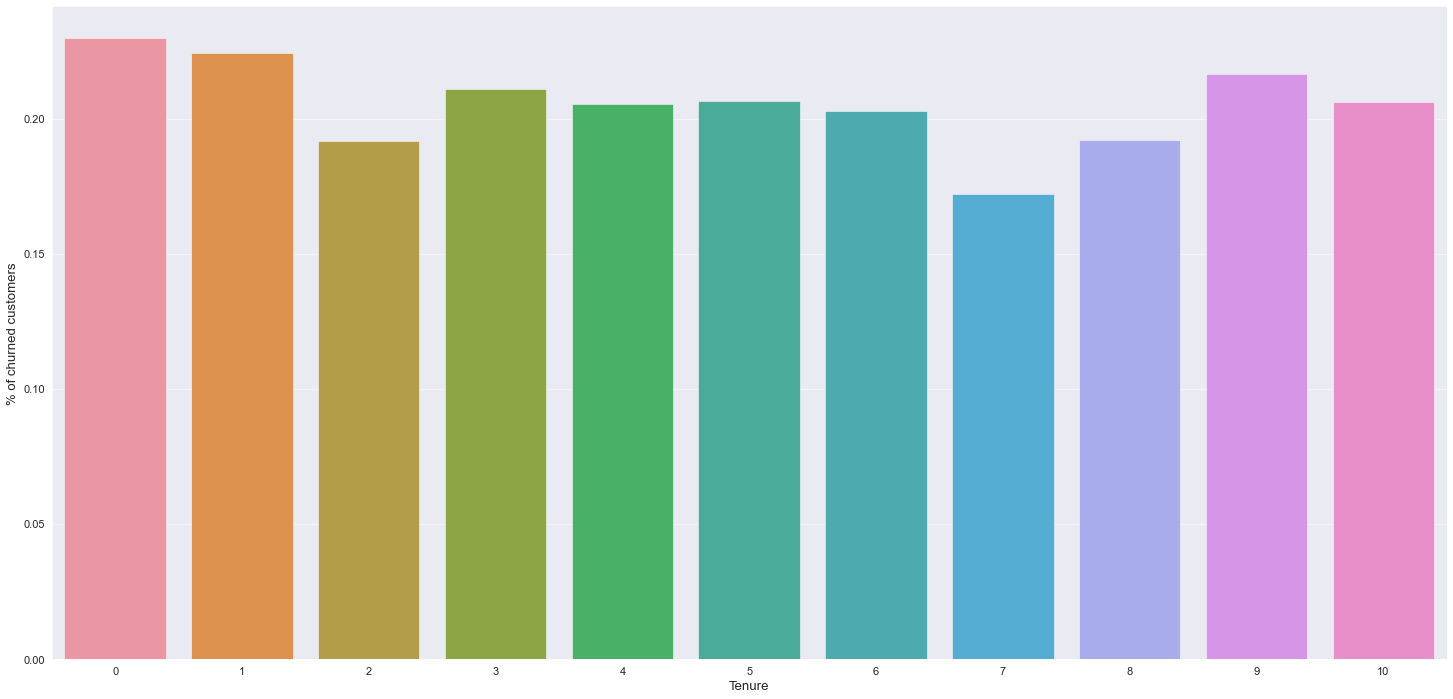

In [26]:
df_aux = df5[['Tenure', 'Exited']].groupby( 'Tenure' ).mean().reset_index()
df_aux.rename( columns={'Exited':'% of churned customers'}, inplace=True )

sns.barplot( x='Tenure', y='% of churned customers', data=df_aux);

### H8. Customers who are not active members are more likely to churn.
* **TRUE** - There is a difference greater than 10% between the churn rate from active and non-active members.

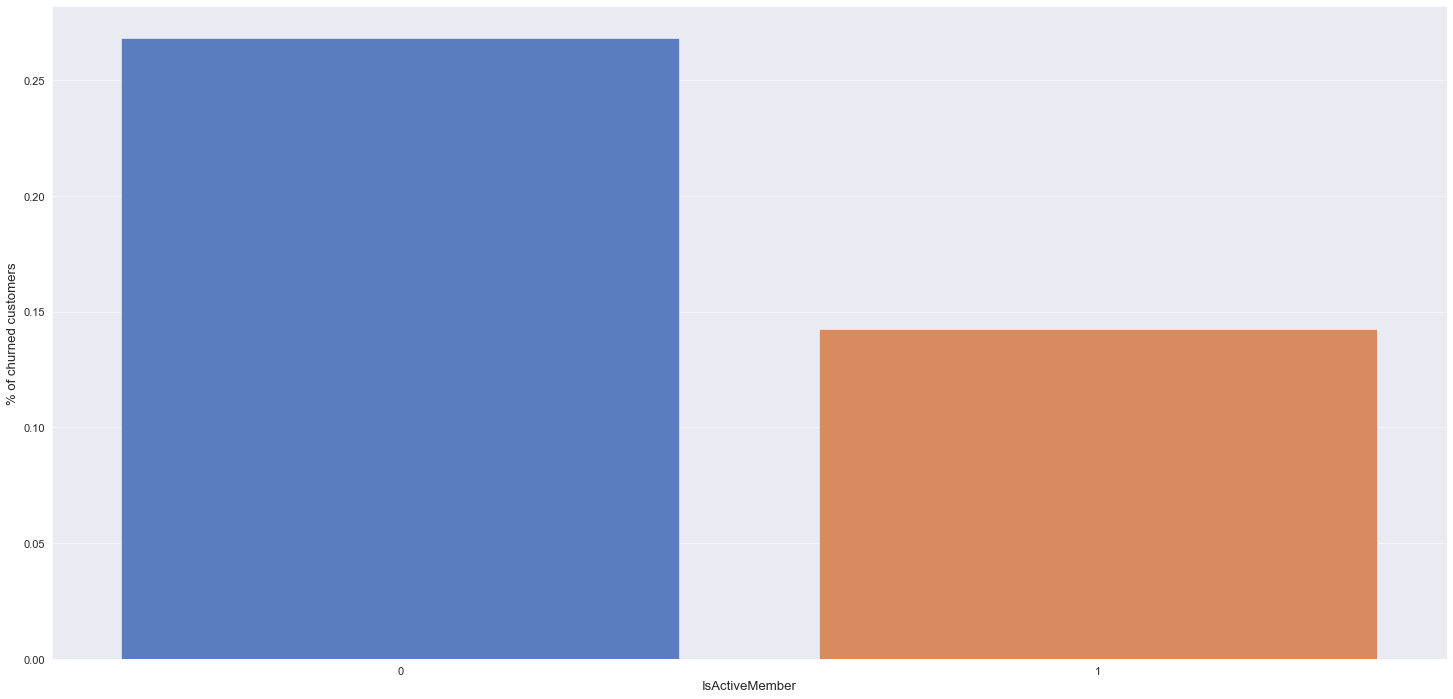

In [27]:
df_aux = df5[['IsActiveMember', 'Exited']].groupby( 'IsActiveMember' ).mean().reset_index()
df_aux.rename( columns={'Exited':'% of churned customers'}, inplace=True )

sns.barplot( x='IsActiveMember', y='% of churned customers', data=df_aux);

# 6. Data Preparation

In [28]:
df6 = df5.copy()

## 6.1. Normalization

## 6.2. Rescaling

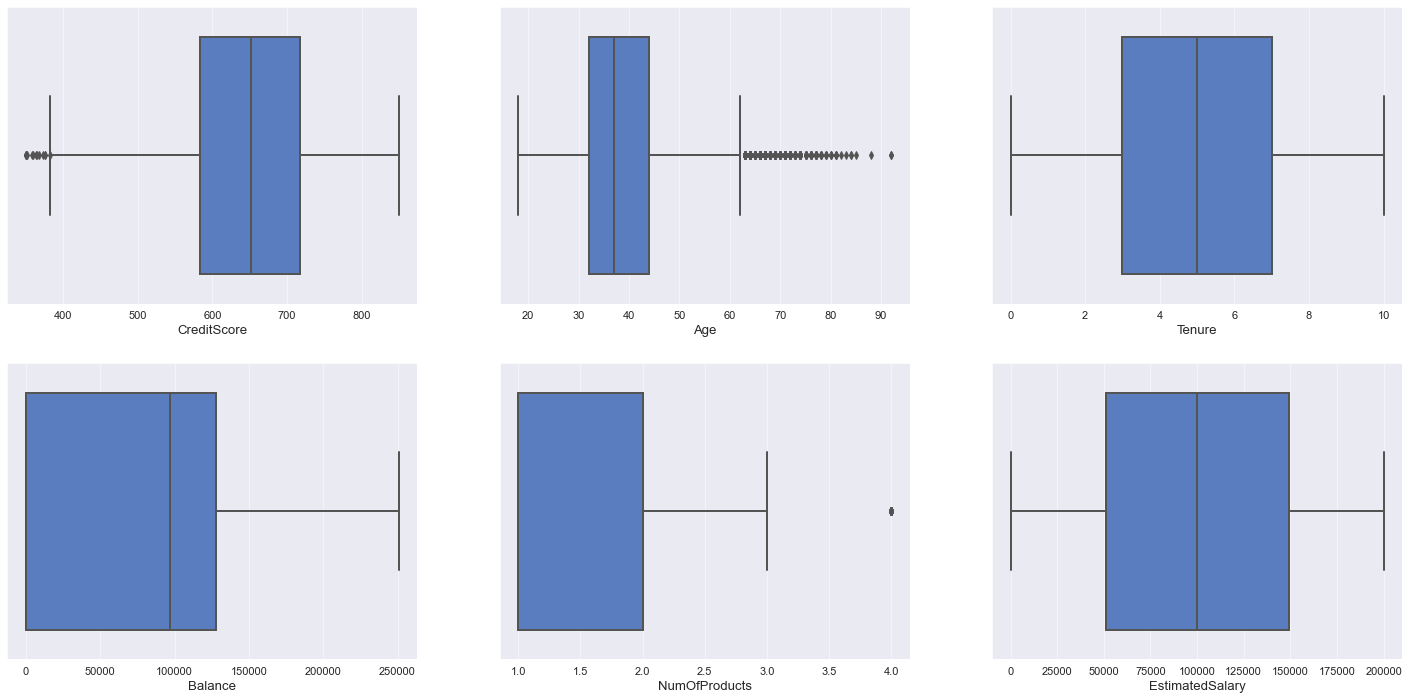

In [29]:
fig, axes = plt.subplots(2,3)

# boxplots for the numerical features
sns.boxplot( x='CreditScore', data=df6, ax=axes[0,0] )
sns.boxplot( x='Age', data=df6, ax=axes[0,1] )
sns.boxplot( x='Tenure', data=df6, ax=axes[0,2] )
sns.boxplot( x='Balance', data=df6, ax=axes[1,0] )
sns.boxplot( x='NumOfProducts', data=df6, ax=axes[1,1] )
sns.boxplot( x='EstimatedSalary', data=df6, ax=axes[1,2] );

In [30]:
rs = RobustScaler()
ms = MinMaxScaler()

# MinMaxScaler
df6['Tenure'] = ms.fit_transform( df6[['Tenure']].values )
df6['Balance'] = ms.fit_transform( df6[['Balance']].values )
df6['EstimatedSalary'] = ms.fit_transform( df6[['EstimatedSalary']].values )

# RobustScaler
df6['Age'] = ms.fit_transform( df6[['Age']].values )
df6['CreditScore'] = ms.fit_transform( df6[['CreditScore']].values )
df6['NumOfProducts'] = ms.fit_transform( df6[['NumOfProducts']].values )

## 6.3. Transformation

### 6.3.1. Encoding

In [31]:
# One Hot Encoding
df6 = pd.get_dummies(df6, prefix=['Geography'], columns=['Geography'] )

# Label Encoding
Gender_dict = {'Male': 0, 'Female': 1}
df6['Gender'] = df6['Gender'].map(Gender_dict)

# 7. Feature Selection

In [32]:
df7 = df6.copy()

In [33]:
df7.head()

,CustomerId,Surname,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain
0,15634602,Hargrave,0.538,1,0.324324,0.2,0.000000,0.000000,1,1,0.506735,1,1,0,0
1,15647311,Hill,0.516,1,0.310811,0.1,0.334031,0.000000,0,1,0.562709,0,0,0,1
2,15619304,Onio,0.304,1,0.324324,0.8,0.636357,0.666667,1,0,0.569654,1,1,0,0
3,15701354,Boni,0.698,1,0.283784,0.1,0.000000,0.333333,0,0,0.469120,0,1,0,0
4,15737888,Mitchell,1.000,1,0.337838,0.2,0.500246,0.000000,1,1,0.395400,0,0,0,1


In [34]:
X = df7.drop( columns=['CustomerId', 'Surname', 'Exited'] )
y = df7['Exited']

In [35]:
X_train, X_test, y_train, y_test = train_test_split( X, y, random_state=42, test_size=0.2  )

## 7.1. Boruta

In [41]:
X_train_n = X_train.values
y_train_n = y_train.values.ravel()

# define RandomForestRegressor
rf = RandomForestRegressor( n_jobs = -1 )

# define Boruta (Activate to run Boruta)
boruta = BorutaPy( rf, n_estimators = 'auto', verbose = 0, random_state = 42 ).fit( X_train_n, y_train_n )

In [44]:
##(Activate after run Boruta)
cols_selected = boruta.support_.tolist()

## best features
X_train_fs = X_train.copy() 
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()
cols_selected_boruta

['Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

## 7.2. Manual Feature Selection

In [45]:
final_cols_selected = X_train.columns

# 8. Machine Learning Model

In [46]:
x_train = X_train[ final_cols_selected ]
x_test = X_test[ final_cols_selected ]

## 8.1. Logistic Regression

In [85]:
# model
lr_model = LogisticRegression().fit( x_train, y_train )

# prediction
y_pred_lr = lr_model.predict( x_test )

# performance
lr_result = ml_metrics( 'Logistic Regression', y_test, y_pred_lr )
lr_result

,Model Name,Accuracy,Recall,F1 Score
0,Logistic Regression,0.8125,0.19084,0.285714


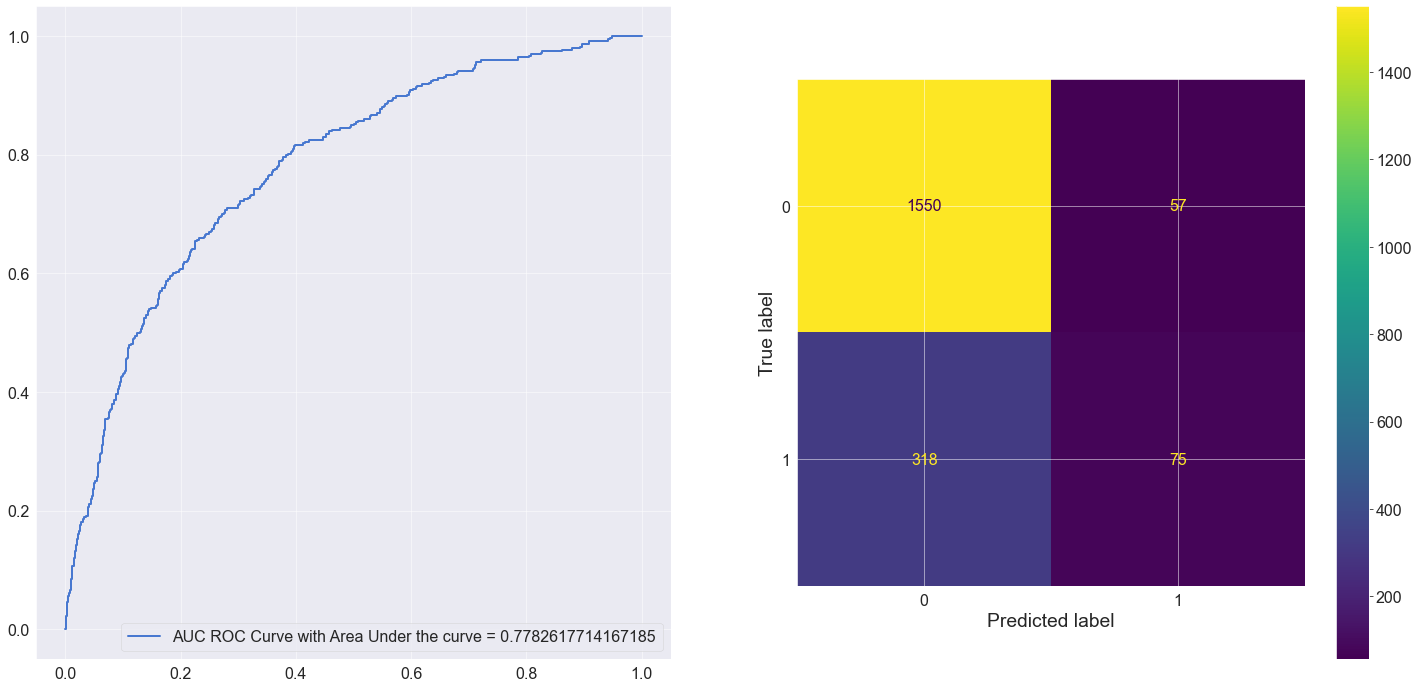

In [95]:
# plot roc auc curve 
plot_metrics(lr_model, X_test, y_test)

## 8.2. Random Forest Classifier

In [96]:
# model
rf_model = RandomForestClassifier().fit( x_train, y_train )

# prediction
y_pred_rf = rf_model.predict( x_test )

# performance
rf_result = ml_metrics( 'Random Forest Classifier', y_test, y_pred_rf )
rf_result

,Model Name,Accuracy,Recall,F1 Score
0,Random Forest Classifier,0.867,0.480916,0.586957


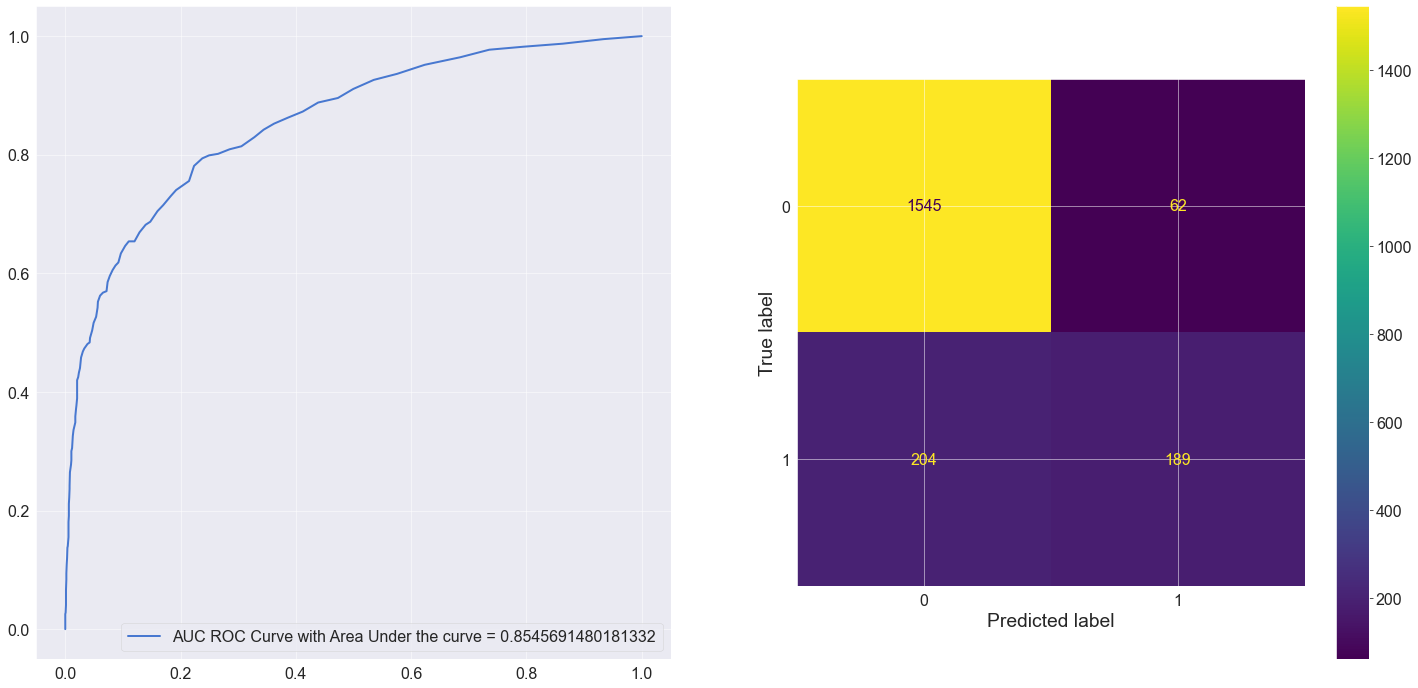

In [97]:
plot_metrics(rf_model, X_test, y_test)